In [1]:
!nvidia-smi
%matplotlib inline

Wed Sep 10 13:52:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:31:00.0 Off |                    0 |
| N/A   30C    P0             50W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import os
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
from typing import List, Literal, List, Dict, Any, Optional
import numpy as np
import seaborn as sns

from datasets import load_dataset
import random
import json
import re
from functools import partial
from datasets import Dataset
from copy import deepcopy
import evaluate
import nltk
from scipy.stats import ttest_ind
import string
from collections import Counter

import openai
import os
import time
import pandas as pd

from ragas.llms import LangchainLLMWrapper
from langchain_deepseek import ChatDeepSeek
from ragas.dataset_schema import SingleTurnSample
from ragas.metrics import AnswerAccuracy
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
# For Snellius
input_csv = "../data/few_shots.csv"
df_few_shots = pd.read_csv(input_csv)
real_csv = "../data/Test_1155.csv"
df_test_1155 = pd.read_csv(real_csv)
learning_csv = "../data/in-context_learning_set.csv"
df_in_context_learning = pd.read_csv(learning_csv)

In [ ]:
"""
module load CUDA/12.4.0
source ~/sglang-venv-2/bin/activate
huggingface-cli login


# 创建所有必要的目录
mkdir -p /scratch-local/yhuang/sglang_cache
mkdir -p /scratch-local/yhuang/huggingface_cache
mkdir -p /scratch-local/yhuang/torch_cache
mkdir -p /scratch-local/yhuang/cuda_cache
mkdir -p /scratch-local/yhuang/xdg_cache
mkdir -p /scratch-local/yhuang/tmp
mkdir -p /scratch-local/yhuang/logs

# 设置所有相关环境变量
export SGLANG_CACHE_DIR=/scratch-local/yhuang/sglang_cache
export TRANSFORMERS_CACHE=/scratch-local/yhuang/huggingface_cache
export HF_HOME=/scratch-local/yhuang/huggingface_cache
export HF_DATASETS_CACHE=/scratch-local/yhuang/huggingface_cache/datasets
export TORCH_HOME=/scratch-local/yhuang/torch_cache
export CUDA_CACHE_PATH=/scratch-local/yhuang/cuda_cache
export XDG_CACHE_HOME=/scratch-local/yhuang/xdg_cache
export TMPDIR=/scratch-local/yhuang/tmp
export TEMP=/scratch-local/yhuang/tmp
export TMP=/scratch-local/yhuang/tmp
export SGLANG_LOG_DIR=/scratch-local/yhuang/logs

# launching
python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-4B --trust-remote-code
CUDA_VISIBLE_DEVICES=0,1 python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-32B --trust-remote-code --tp 2
"""

## Loading the GoogleNQ sample

In [3]:
import os

os.environ["HF_DATASETS_CACHE"] = "/scratch-local/yhuang/huggingface_cache"
# 确保目录存在
os.makedirs('/scratch-local/yhuang/huggingface_cache', exist_ok=True)

In [4]:
GoogleNQ_sample = load_dataset(
    "json",
    data_files="GoogleNQ_sample.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

GoogleNQ_pilot = load_dataset(
    "json",
    data_files="NQ_baseline_test.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

## Using the off-the-shelf Qwen3-4B for classification

#### Prompt setting

In [5]:
system_prompt = """
You are an expert analyst. Your task is to analyze and determine whether an input user query is "fully specified" or "underspecified".

"""

task_FS_UND = """
Analyze the following input user query:

{"query": "TARGET"}

Please provide your analysis in the following JSON format:

{"query": "TARGET", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}
"""

#### Loading the model

In [6]:
Qwen3_4B = "Qwen/Qwen3-4B"

import os
os.environ['TRANSFORMERS_CACHE'] = '/scratch-local/yhuang/huggingface_cache'
# 确保目录存在
os.makedirs('/scratch-local/yhuang/huggingface_cache', exist_ok=True)

# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained(Qwen3_4B, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(Qwen3_4B)

# 将模型移到可用设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

cuda


#### Helper functions

In [7]:
def batch_generate_responses_qwen3(prompts, system_prompt=system_prompt,
                             temperature=0.7, max_new_tokens=32768, batch_size=5,
                             enable_thinking=True, parse_thinking=True):
    """
    批量生成Qwen 3模型的回复

    参数:
        prompts: 字符串列表，每个字符串是一个提示词
        system_prompt: 系统提示词
        max_new_tokens: 生成的最大token数，默认为512
        batch_size: 每批处理的提示词数量，默认为4
        enable_thinking: 是否启用思考模式，默认为True
        parse_thinking: 是否解析思考内容，默认为True

    返回:
        如果parse_thinking=True，返回(思考内容列表, 回复内容列表)的元组
        如果parse_thinking=False，返回回复列表
    """

    responses = []
    thinking_contents = [] if parse_thinking else None

    # 按批次处理
    for i in tqdm(range(0, len(prompts), batch_size)):
        batch_prompts = prompts[i:i+batch_size]
        batch_texts = []

        # 为每个提示词准备输入文本
        for prompt in batch_prompts:
            if system_prompt:
                messages = [
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": prompt}
                ]
            else:
                messages = [
                    {"role": "user", "content": prompt}
                ]

            text = tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True,
                enable_thinking=enable_thinking  # 启用思考模式
            )
            batch_texts.append(text)

        # 批量编码输入
        model_inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(model.device)

        # 生成回复
        with torch.no_grad():
            generated_ids = model.generate(
                **model_inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=temperature,
                top_p=0.9,
                repetition_penalty=1.2
            )

        # 处理生成的回复
        batch_responses = []
        batch_thinking = [] if parse_thinking else None

        for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids):
            response_ids = output_ids[len(input_ids):].tolist()

            if parse_thinking and enable_thinking:
                # 解析思考内容
                try:
                    # 寻找</think>对应的token ID (151668)
                    index = len(response_ids) - response_ids[::-1].index(151668)
                except ValueError:
                    index = 0

                thinking_content = tokenizer.decode(response_ids[:index], skip_special_tokens=True).strip("\n")
                content = tokenizer.decode(response_ids[index:], skip_special_tokens=True).strip("\n")

                batch_thinking.append(thinking_content)
                batch_responses.append(content)
            else:
                # 不解析思考内容，直接返回完整回复
                response = tokenizer.decode(response_ids, skip_special_tokens=True)
                batch_responses.append(response)

        responses.extend(batch_responses)
        if parse_thinking:
            thinking_contents.extend(batch_thinking)

    if parse_thinking:
        return thinking_contents, responses
    else:
        return responses

def get_judgments_from_responses(responses: List[str]) -> List[Optional[str]]:
    """
    推荐的解析函数，结合了多种方法的优点
    """
    judgments = []

    for i, response in enumerate(responses):
        judgment = None

        try:
            # 方法1: 尝试直接解析JSON
            clean_response = response.strip()
            if clean_response.startswith('{') and clean_response.endswith('}'):
                data = json.loads(clean_response)
                judgment = data.get('judgment')
            else:
                # 方法2: 寻找JSON部分
                start_idx = clean_response.find('{')
                end_idx = clean_response.rfind('}')
                if start_idx != -1 and end_idx != -1:
                    json_part = clean_response[start_idx:end_idx+1]
                    data = json.loads(json_part)
                    judgment = data.get('judgment')

        except json.JSONDecodeError:
            # 方法3: 使用正则表达式作为后备
            pattern = r'"judgment"\s*:\s*"([^"]*)"'
            match = re.search(pattern, response)
            if match:
                judgment = match.group(1)

        if judgment is None:
            print(f"Warning: response {i} cannot retrieve judgment")
            print(f"Respond content: {response[:200]}...")
            judgment = "error"

        judgments.append(judgment)

    return judgments



def run_experiment(input_prompts, test_df):
  output = batch_generate_responses_qwen3(input_prompts)
  df = test_df.copy()
  df['thinking'] = output[0]
  df['model_response'] = output[1]
  to_process = output[1]
  processed_judgments = get_judgments_from_responses(to_process)
  df['model_pred'] = processed_judgments

  return df

def prepare_test_prompts(test_df, task_text, learning_df=None, instruction_text=None, theory=False):
  print("Start preparing prompts...")
  if learning_df is not None and instruction_text is not None:
    print(f"# learning samples: {len(learning_df)}")
    examples = []
    if theory:
      for _, row in learning_df.iterrows():
        example = {
                "query": row['request'],
                "reasoning": row['reasoning'],
                "category": row['category'],
                "judgment": row['gold_judgment']
              }
        examples.append(json.dumps(example, ensure_ascii=False))

      examples_text = '\n\n'.join(examples)
      base_prompt = instruction_text + examples_text + task_text
    else:
      for _, row in learning_df.iterrows():
        example = {
                "query": row['request'],
                "judgment": row['gold_judgment']
              }
        examples.append(json.dumps(example, ensure_ascii=False))

      examples_text = '\n\n'.join(examples)
      base_prompt = instruction_text + examples_text + task_text

  else:
    base_prompt = task_text

  print(f"# Testing data points: {len(test_df)}")
  test_prompts = []
  for _, row in test_df.iterrows():
    query = row['question']
    complete_prompt = base_prompt.replace("TARGET", query)
    test_prompts.append(complete_prompt)

  print(f"Generation complete: {len(test_prompts)} prompts")

  avg_length = sum(len(p) for p in test_prompts) // len(test_prompts)
  print(f"Average prompt length: {avg_length:,} bytes (~{avg_length//4:,} tokens)")

  return test_prompts


def add_columns_to_dataset(dataset, columns_dict, inplace=False):
    """
    Adding multiple columns to a HuggingFace Dataset

    params：
        dataset (Dataset): The original dataset
        columns_dict (dict): The new columns organized in a dict, keys are column names, value lists should be of the same length with Dataset
        inplace (bool): whether to change the orignial Dataset or create a new copy

    return：
        Dataset: The new dataset with new columns added
    """
    if not inplace:
        dataset = deepcopy(dataset)

    for column_name, values in columns_dict.items():
        if len(values) != len(dataset):
            raise ValueError(f"Length mismatch：'{column_name}' The column length is {len(values)}, but the dataset has {len(dataset)} samples.")
        dataset = dataset.add_column(column_name, values)

    return dataset

def merge_df_into_dataset_by_order(dataset, df: pd.DataFrame, 
                                   columns=None, prefix: str="", inplace=False):
    """
    将 DataFrame 的指定列，按行顺序写回 HuggingFace Dataset。
    要求：df 与 dataset 行顺序一致、长度相同。
    """
    if columns is None:
        # 默认把 df 的所有列都写回（可用 prefix 避免重名）
        columns = list(df.columns)

    if len(df) != len(dataset):
        raise ValueError(f"Length mismatch: df={len(df)} vs dataset={len(dataset)}.")

    # 将 NaN -> None，并转成 Python 原生类型列表
    columns_dict = {}
    for col in columns:
        series = df[col]
        # 统一把 NaN 转成 None
        values = series.where(series.notna(), None).tolist()
        columns_dict[f"{prefix}{col}"] = values

    # 你已有的工具函数
    updated_dataset = add_columns_to_dataset(dataset, columns_dict, inplace=inplace)
    return updated_dataset

#### Direct classification with Qwen3-4B

In [8]:
df_GoogleNQ_sample = pd.read_json("GoogleNQ_sample.jsonl", lines=True)
test_prompts = prepare_test_prompts(df_GoogleNQ_sample, task_FS_UND)
print(test_prompts[0])

Start preparing prompts...
# Testing data points: 1000
Generation complete: 1000 prompts
Average prompt length: 316 bytes (~79 tokens)

Analyze the following input user query:

{"query": "where does the modern view of history originate from"}

Please provide your analysis in the following JSON format:

{"query": "where does the modern view of history originate from", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}



In [9]:
test_df = run_experiment(test_prompts, df_GoogleNQ_sample)
test_df.to_csv('BASELINE_GoogleNQ_classification_all.csv')
test_df

100%|██████████| 200/200 [1:39:45<00:00, 29.93s/it]


,question,short_answers,long_answer,thinking,model_response,model_pred
0,where does the modern view of history originat...,[approximately in the early 16th century],The early modern period began approximately ...,"<think>\nOkay, let's see. The user is asking w...","{\n ""query"": ""where does the modern view of h...",underspecified
1,when was the first book made into a movie,[1924],"In 1924 , Erich von Stroheim attempted a lite...","<think>\nOkay, let's see. The user is asking, ...","{\n ""query"": ""when was the first book made in...",fully specified
2,when did the study of media effects begin,[1919],The social impact of mass communication has b...,"<think>\nOkay, let's see. The user is asking w...","{\n ""query"": ""when did the study of media eff...",fully specified
3,where are the giant redwoods located in califo...,"[Humboldt County, Del Norte County]",Redwood National and State Parks IUCN c...,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""where are the giant redwoods lo...",fully specified
4,when did the first wireless beats come out,[October 2012],"In October 2012 , Beats unveiled its first tw...","<think>\nOkay, let's see. The user is asking w...","{\n ""query"": ""when did the first wireless bea...",underspecified
...,...,...,...,...,...,...
995,who is the drummer for guns and roses,[Frank Ferrer],Image Name Years active Instruments ...,"<think>\nOkay, let's see. The user is asking, ...","{\n ""query"": ""who is the drummer for guns and...",underspecified
996,where was the movie 500 days of summer filmed,[Los Angeles],David Ng of the Los Angeles Times describes a...,"<think>\nOkay, let's see. The user is asking w...","{\n ""query"": ""where was the movie 500 days ...",fully specified
997,what was the lowest barometric pressure for hu...,[914 mbar (hPa; 27.0 inHg)],In between Rita and Katrina is Hurricane Alle...,"<think>\nOkay, let's see. The user is asking a...","{\n ""query"": ""what was the lowest barometric ...",fully specified
998,what is the meaning of auv in cars,[action utility vehicles],"In Australia and New Zealand , the term SUV i...","<think>\nOkay, let's see. The user is asking f...","{\n ""query"": ""what is the meaning of auv in c...",underspecified


In [10]:
annotated_dataset = merge_df_into_dataset_by_order(
    GoogleNQ_sample, 
    test_df, 
    columns=["thinking", "model_response", "model_pred"],
    prefix="qwen3_",
    inplace=False
)

In [11]:
# Create the UND subset
underspecified_set = annotated_dataset.filter(
    lambda x: x["qwen3_model_pred"].strip().lower() == "underspecified"
)

# Create the FS subset
fully_specified_set = annotated_dataset.filter(
    lambda x: x["qwen3_model_pred"].strip().lower() == "fully specified"
)

# The size of subsets
print(f"Underspecified samples: {len(underspecified_set)}")
print(f"Fully specified samples: {len(fully_specified_set)}")

annotated_dataset.to_json("BASELINE_classified_GoogleNQ_sample_all.jsonl", orient="records", lines=True)
underspecified_set.to_json("BASELINE_classified_GoogleNQ_sample_UND.jsonl", orient="records", lines=True)
fully_specified_set.to_json("BASELINE_classified_GoogleNQ_sample_FS.jsonl", orient="records", lines=True)

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Underspecified samples: 458
Fully specified samples: 542


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

2325542

## QA implementations

#### Loading back the classified subsets

In [6]:
underspecified_set = load_dataset(
    "json",
data_files="BASELINE_classified_GoogleNQ_sample_UND.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

fully_specified_set = load_dataset(
    "json",
data_files="BASELINE_classified_GoogleNQ_sample_FS.jsonl",
    split="train"
)

#### Loading an LLM for short and long QA programs

In [ ]:
from openai import OpenAI

client = OpenAI()

In [4]:
def ask_short_answer(question, client, model="gpt-4o-2024-11-20", temperature=0, max_retries=5, sleep_time=2.0):
    system_prompt = (
        "Answer the question with a concise response. "
        "Return answers as a list of strings. If there's only one answer, return a single-item list. "
        "Each answer should be brief and direct."
    )
    retries = 0
    while retries < max_retries:
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": question}
                ],
                temperature=temperature
            )
            content = response.choices[0].message.content
            if content.startswith("["):
                return eval(content)
            else:
                return [content.strip()]
        except Exception as e:
            retries += 1
            time.sleep(sleep_time * retries)
            
    return ["[Error]: Max retries exceeded"]

def ask_long_answer(question, client, model="gpt-4o-2024-11-20", temperature=0.7, max_retries=5, sleep_time=2.0):
    system_prompt = (
        "Answer the question thoroughly and helpfully. Provide context, explanations, and relevant details "
        "from Wikipedia that would help the user understand the topic better."
    )
    retries = 0
    while retries < max_retries:
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": question}
                ],
                temperature=temperature
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            retries += 1
            time.sleep(sleep_time * retries)
    return "[Error]: Max retries exceeded"

### Helper functions to run QA in batches

In [5]:
def run_batch_shortQA_api(batch, client, **kwargs):
    short_answers = []
    for q in batch["question"]:
        try:
            answer = ask_short_answer(q, client=client, **kwargs)
            short_answers.append(answer)
        except Exception as e:
            print(f"Error: {e}")
            short_answers.append(["error"])
    return {"model_short_answer": short_answers}

def run_batch_longQA_api(batch, client, **kwargs):
    long_answers = []
    for q in batch["question"]:
        try:
            answer = ask_long_answer(q, client=client, **kwargs)
            long_answers.append(answer)
        except Exception as e:
            print(f"Error: {e}")
            long_answers.append("error")
    return {"model_long_answer": long_answers}

def batch_QA_with_progress(dataset, batch_fn, output_key, batch_size=10, fill_value="error", **batch_fn_kwargs):
    all_outputs = []
    for i in tqdm(range(0, len(dataset), batch_size), desc=f"Running {output_key}"):
        batch = dataset.select(range(i, min(i + batch_size, len(dataset))))
        try:
            output = batch_fn(batch, **batch_fn_kwargs)
            if output_key not in output:
                raise ValueError(f"Missing key '{output_key}' in batch result")
            all_outputs.extend(output[output_key])
        except Exception as e:
            print(f"Batch error at {i}: {e}")
            all_outputs.extend([fill_value] * len(batch))

    if len(all_outputs) != len(dataset):
        print(f"[Warning] Output length mismatch, auto-filling")
        all_outputs.extend([fill_value] * (len(dataset) - len(all_outputs)))

    return {output_key: all_outputs}

#### Implementation

In [7]:
short_results_UND = batch_QA_with_progress(
    underspecified_set,
    batch_fn=run_batch_shortQA_api,
    output_key="model_short_answer",
    fill_value=["error"],
    client=client,
    model="gpt-4o-2024-11-20",
    temperature=0.0
)

Running model_short_answer: 100%|██████████| 46/46 [06:29<00:00,  8.48s/it]


In [8]:
long_results_UND = batch_QA_with_progress(
    underspecified_set,
    batch_fn=run_batch_longQA_api,
    output_key="model_long_answer",
    fill_value="error",
    client=client,
    model="gpt-4o-2024-11-20",
    temperature=0.7
)

Running model_long_answer: 100%|██████████| 46/46 [1:10:20<00:00, 91.74s/it] 


In [9]:
# batch QA for FS
short_results_FS = batch_QA_with_progress(
    fully_specified_set,
    batch_fn=run_batch_shortQA_api,
    output_key="model_short_answer",
    fill_value=["error"],
    client=client,
    model="gpt-4o-2024-11-20",
    temperature=0.0
)

Running model_short_answer: 100%|██████████| 55/55 [06:51<00:00,  7.49s/it]


In [10]:
long_results_FS = batch_QA_with_progress(
    fully_specified_set,
    batch_fn=run_batch_longQA_api,
    output_key="model_long_answer",
    fill_value="error",
    client=client,
    model="gpt-4o-2024-11-20",
    temperature=0.7
)

Running model_long_answer: 100%|██████████| 55/55 [1:05:23<00:00, 71.34s/it]


In [11]:
qa_underspecified = deepcopy(underspecified_set)

for key in short_results_UND:
    qa_underspecified = qa_underspecified.add_column(key, short_results_UND[key])
for key in long_results_UND:
    qa_underspecified = qa_underspecified.add_column(key, long_results_UND[key])

qa_underspecified.to_json("BASELINE_GoogleNQ_UND_qa_gpt.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

3151804

In [12]:
qa_fully_specified = deepcopy(fully_specified_set)

for key in short_results_FS:
    qa_fully_specified = qa_fully_specified.add_column(key, short_results_FS[key])

qa_fully_specified.to_json("BASELINE_GoogleNQ_FS_qa_gpt.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

2362837

In [13]:
fully_specified_set = load_dataset(
    "json",
    data_files="BASELINE_GoogleNQ_FS_qa_gpt.jsonl",
    split="train"
)
qa_fully_specified = deepcopy(fully_specified_set)

for key in long_results_FS:
    qa_fully_specified = qa_fully_specified.add_column(key, long_results_FS[key])

qa_fully_specified.to_json("BASELINE_GoogleNQ_FS_qa_gpt.jsonl", orient="records", lines=True)

Generating train split: 0 examples [00:00, ? examples/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

3521294

In [15]:
df = pd.read_json("BASELINE_GoogleNQ_UND_qa_gpt.jsonl", lines=True)
df.to_csv('BASELINE_GoogleNQ_UND_qa_gpt.csv')

df = pd.read_json("BASELINE_GoogleNQ_FS_qa_gpt.jsonl", lines=True)
df.to_csv('BASELINE_GoogleNQ_FS_qa_gpt.csv')

In [16]:
df

,question,short_answers,long_answer,qwen3_thinking,qwen3_model_response,qwen3_model_pred,model_short_answer,model_long_answer
0,when was the first book made into a movie,[1924],"In 1924 , Erich von Stroheim attempted a lite...","<think>\nOkay, let's see. The user is asking, ...","{\n ""query"": ""when was the first book made in...",fully specified,[1900 - The first book adapted into a movie wa...,The first book adaptation into a movie dates b...
1,when did the study of media effects begin,[1919],The social impact of mass communication has b...,"<think>\nOkay, let's see. The user is asking w...","{\n ""query"": ""when did the study of media eff...",fully specified,[The study of media effects began in the early...,The study of media effects began in the early ...
2,where are the giant redwoods located in califo...,"[Humboldt County, Del Norte County]",Redwood National and State Parks IUCN c...,"<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""where are the giant redwoods lo...",fully specified,[- Redwood National and State Parks \n- Sequo...,"The giant redwoods, also known as **coastal re..."
3,who has won the most games in nfl 2017,[Dallas Cowboys],Rank Team Won Lost Tied Pct . F...,"<think>\nOkay, let's see. The user is asking ""...","{\n ""query"": ""who has won the most games in n...",fully specified,[New England Patriots],The 2017 NFL regular season ran from September...
4,where are more than half your bones located,[the appendicular skeleton],The skeleton of an adult human consists of 20...,"<think>\nOkay, let's see. The user asked, ""Whe...","{\n ""query"": ""where are more than half your b...",fully specified,[In your hands and feet.],More than half of the bones in the human body ...
...,...,...,...,...,...,...,...,...
537,when did dragon ball z air in australia,[Fall 1998],The Funimation dubbed episodes also aired in ...,"<think>\nOkay, let's see. The user is asking w...","{\n ""query"": ""when did dragon ball z air in a...",fully specified,[Dragon Ball Z first aired in Australia on Jul...,"""Dragon Ball Z,"" the highly popular Japanese a..."
538,a synonym for the content component of communi...,[information],"In publishing , art , and communication , con...","<think>\nOkay, let's see. The user is asking f...","{\n ""query"": ""a synonym for the content compo...",fully specified,[Message],A synonym for the **content component** of com...
539,when was the last time minnesota vikings was i...,[XI],"Since the team 's first season in 1961 , the ...","<think>\nOkay, let's see. The user is asking w...","{\n ""query"": ""when was the last time minnesot...",fully specified,"[January 9, 1977]",The Minnesota Vikings last appeared in the Sup...
540,where was the movie 500 days of summer filmed,[Los Angeles],David Ng of the Los Angeles Times describes a...,"<think>\nOkay, let's see. The user is asking w...","{\n ""query"": ""where was the movie 500 days ...",fully specified,"[Los Angeles, California]",The movie *500 Days of Summer* (2009) was prim...


## Evaluations

In [17]:
underspecified_set_qa = load_dataset(
    "json",
    data_files="BASELINE_GoogleNQ_UND_qa_gpt.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

fully_specified_set_qa = load_dataset(
    "json",
    data_files="BASELINE_GoogleNQ_FS_qa_gpt.jsonl",
    split="train"
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

#### Squad EM + F1

In [18]:
# Official squad script for avg EM and F1, not possible for t-test


# Evaluate fully specified subset
dataset = load_dataset("json", data_files="BASELINE_GoogleNQ_FS_qa_gpt.jsonl", split="train")

# 加载 HuggingFace 的 squad 评估器
squad_metric = evaluate.load("squad")

# 构造 predictions 和 references（标准格式）
predictions = [
    {
        "id": str(i),
        "prediction_text": pred[0] if isinstance(pred, list) and pred else ""
    }
    for i, pred in enumerate(dataset["model_short_answer"])
]

references = [
    {
        "id": str(i),
        "answers": {
            "text": ref if isinstance(ref, list) else [ref],
            "answer_start": [0] * len(ref if isinstance(ref, list) else [ref])
        }
    }
    for i, ref in enumerate(dataset["short_answers"])
]

# 计算 SQuAD-style EM 和 F1
results = squad_metric.compute(predictions=predictions, references=references)

# 打印平均指标
print(f"Exact Match: {results['exact_match']:.2f}")
print(f"F1 Score: {results['f1']:.2f}")

Exact Match: 30.81
F1 Score: 48.11


In [19]:
# Evaluate underspecified subset
dataset = load_dataset("json", data_files="BASELINE_GoogleNQ_UND_qa_gpt.jsonl", split="train")

# 加载 HuggingFace 的 squad 评估器
squad_metric = evaluate.load("squad")

# 构造 predictions 和 references（标准格式）
predictions = [
    {
        "id": str(i),
        "prediction_text": pred[0] if isinstance(pred, list) and pred else ""
    }
    for i, pred in enumerate(dataset["model_short_answer"])
]

references = [
    {
        "id": str(i),
        "answers": {
            "text": ref if isinstance(ref, list) else [ref],
            "answer_start": [0] * len(ref if isinstance(ref, list) else [ref])
        }
    }
    for i, ref in enumerate(dataset["short_answers"])
]

# 计算 SQuAD-style EM 和 F1
results = squad_metric.compute(predictions=predictions, references=references)

# 打印平均指标
print(f"Exact Match: {results['exact_match']:.2f}")
print(f"F1 Score: {results['f1']:.2f}")

Exact Match: 17.90
F1 Score: 35.88


In [20]:
def evaluate_squad_per_sample_multi_ref_pred(dataset, pred_col="model_short_answer", ref_col="short_answers"):
    """
    对每个样本逐一计算 EM 和 F1，支持多个参考答案和多个预测答案（list[str]）。
    返回带 "em", "f1" 列的新 Dataset，以及 f1/em 列表用于统计分析。
    Also considering multiple answers in both gold and pred and take the maximum score
    """

    def normalize_answer(s):
        def remove_articles(text):
            return re.sub(r'\b(a|an|the)\b', ' ', text)
        def white_space_fix(text):
            return ' '.join(text.split())
        def remove_punc(text):
            return ''.join(ch for ch in text if ch not in string.punctuation)
        def lower(text):
            return text.lower()
        return white_space_fix(remove_articles(remove_punc(lower(s))))

    def compute_exact(a_pred, a_gold):
    # 如果是 list，转成 set 并 normalize 每个元素
        if isinstance(a_pred, list) and isinstance(a_gold, list):
          pred_set = set(normalize_answer(a) for a in a_pred)
          gold_set = set(normalize_answer(a) for a in a_gold)
          return int(pred_set == gold_set)
        else:
          return int(normalize_answer(a_pred) == normalize_answer(a_gold))

    def compute_f1(a_pred, a_gold):
        pred_tokens = normalize_answer(a_pred).split()
        gold_tokens = normalize_answer(a_gold).split()
        common = Counter(pred_tokens) & Counter(gold_tokens)
        num_same = sum(common.values())
        if num_same == 0:
            return 0.0
        precision = num_same / len(pred_tokens)
        recall = num_same / len(gold_tokens)
        return 2 * precision * recall / (precision + recall)

    new_data = []
    f1_scores = []
    em_scores = []

    for item in dataset:
        preds = item.get(pred_col, [])
        golds = item.get(ref_col, [])
        # 转为 list
        if not isinstance(preds, list):
            preds = [preds] if preds else []
        if not isinstance(golds, list):
            golds = [golds] if golds else []

        # 多对多最大匹配
        if not preds or not golds:
            em = 0.0
            f1 = 0.0
        else:
            em = max(compute_exact(p, g) for p in preds for g in golds)
            f1 = max(compute_f1(p, g) for p in preds for g in golds)

        new_item = deepcopy(item)
        new_item["em"] = em
        new_item["f1"] = f1
        new_data.append(new_item)
        em_scores.append(em)
        f1_scores.append(f1)

    return Dataset.from_list(new_data), f1_scores, em_scores

In [21]:
squad_scored_UND, UND_f1_list, UND_em_list = evaluate_squad_per_sample_multi_ref_pred(underspecified_set_qa)
squad_scored_UND.to_json("BASELINE_Google_NQ_UND_qa_gpt_with_squad_scores.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

3160528

In [22]:
squad_scored_FS, FS_f1_list, FS_em_list = evaluate_squad_per_sample_multi_ref_pred(fully_specified_set_qa)
squad_scored_FS.to_json("BASELINE_Google_NQ_FS_qa_gpt_with_squad_scores.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

3531311

In [23]:
df = pd.read_json("BASELINE_Google_NQ_UND_qa_gpt_with_squad_scores.jsonl", lines=True)
df.to_csv('BASELINE_Google_NQ_UND_qa_gpt_with_squad_scores.csv')

df = pd.read_json("BASELINE_Google_NQ_FS_qa_gpt_with_squad_scores.jsonl", lines=True)
df.to_csv('BASELINE_Google_NQ_FS_qa_gpt_with_squad_scores.csv')

In [24]:
UND_mean_em = np.mean(UND_em_list)  # em_scores: EM list per sample
UND_mean_f1 = np.mean(UND_f1_list)  # f1_scores F1 list per sample
print(f"UND Exact Match (avg): {UND_mean_em * 100:.2f}")
print(f"UND F1 Score (avg): {UND_mean_f1 * 100:.2f}")

FS_mean_em = np.mean(FS_em_list)  # em_scores: EM list per sample
FS_mean_f1 = np.mean(FS_f1_list)  # f1_scores F1 list per sample
print(f"FS Exact Match (avg): {FS_mean_em * 100:.2f}")
print(f"FS F1 Score (avg): {FS_mean_f1 * 100:.2f}")

f1_tstat, f1_pval = ttest_ind(FS_f1_list, UND_f1_list, equal_var=False)
print(f"F1: t={f1_tstat:.3f}, p={f1_pval:.4f}")

em_tstat, em_pval = ttest_ind(FS_em_list, UND_em_list, equal_var=False)
print(f"EM: t={em_tstat:.3f}, p={em_pval:.4f}")

UND Exact Match (avg): 18.78
UND F1 Score (avg): 36.98
FS Exact Match (avg): 31.37
FS F1 Score (avg): 48.60
F1: t=4.670, p=0.0000
EM: t=4.654, p=0.0000


#### Visualization

In [25]:
df_f1 = pd.DataFrame({
    "F1": FS_f1_list + UND_f1_list,
    "Subset": ["Fully specified"] * len(FS_f1_list) + ["Underspecified"] * len(UND_f1_list)
})

plt.figure(figsize=(6, 4))
ax = sns.boxplot(x="Subset", y="F1", data=df_f1, palette="Set2", showfliers=False)

# 计算中位数
medians = df_f1.groupby("Subset")["F1"].median()

# 标注中位数数值
for i, (subset, median_val) in enumerate(medians.items()):
    ax.text(
        i, median_val + 0.03, f"{median_val:.2f}",
        ha='center', va='bottom', fontsize=11, weight='bold', color='black'
    )

plt.title("gpt-4o-2024-11-20 F1 Score Distribution by Subset_BASELINE - GoogleNQ")
plt.ylim(-0.05, 1.05)
plt.ylabel("F1 Score")
plt.xlabel("")
plt.tight_layout()
plt.savefig("GoogleNQ_f1_boxplot_gpt_BASELINE.png", dpi=300)
plt.close()

df_em = pd.DataFrame({
    "EM": FS_em_list + UND_em_list,
    "Subset": ["Fully specified"] * len(FS_em_list) + ["Underspecified"] * len(UND_em_list)
})

plt.figure(figsize=(6, 4))
sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)
plt.title("gpt-4o-2024-11-20 Exact Match Rate by Subset_BASELINE (± CI) - GoogleNQ")
plt.tight_layout()
plt.savefig("GoogleNQ_em_barplot_gpt_BASELINE.png", dpi=300)
plt.close()

/scratch-local/yhuang.14598269/ipykernel_2864419/1062261962.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Subset", y="F1", data=df_f1, palette="Set2", showfliers=False)
/scratch-local/yhuang.14598269/ipykernel_2864419/1062261962.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)
/scratch-local/yhuang.14598269/ipykernel_2864419/1062261962.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)


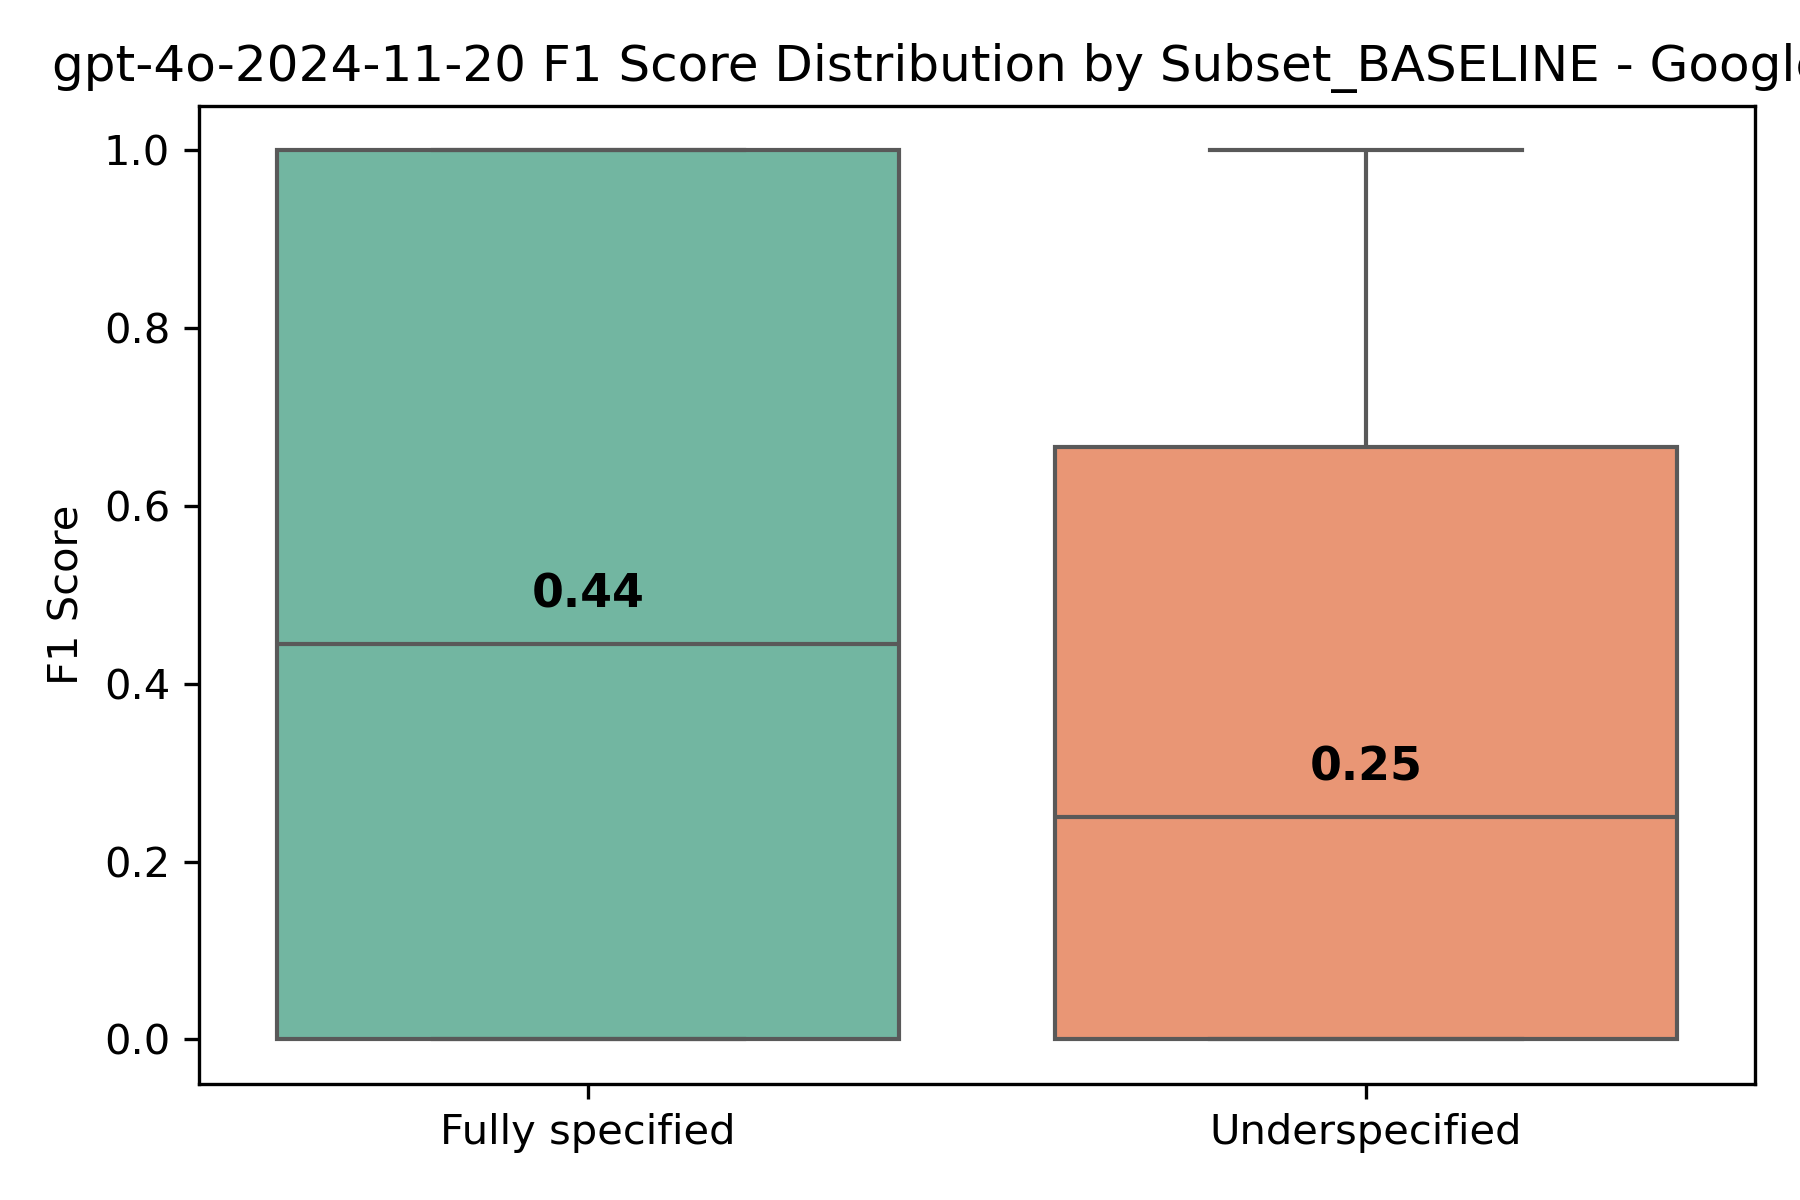

In [26]:
from IPython.display import Image
Image("GoogleNQ_f1_boxplot_gpt_BASELINE.png")

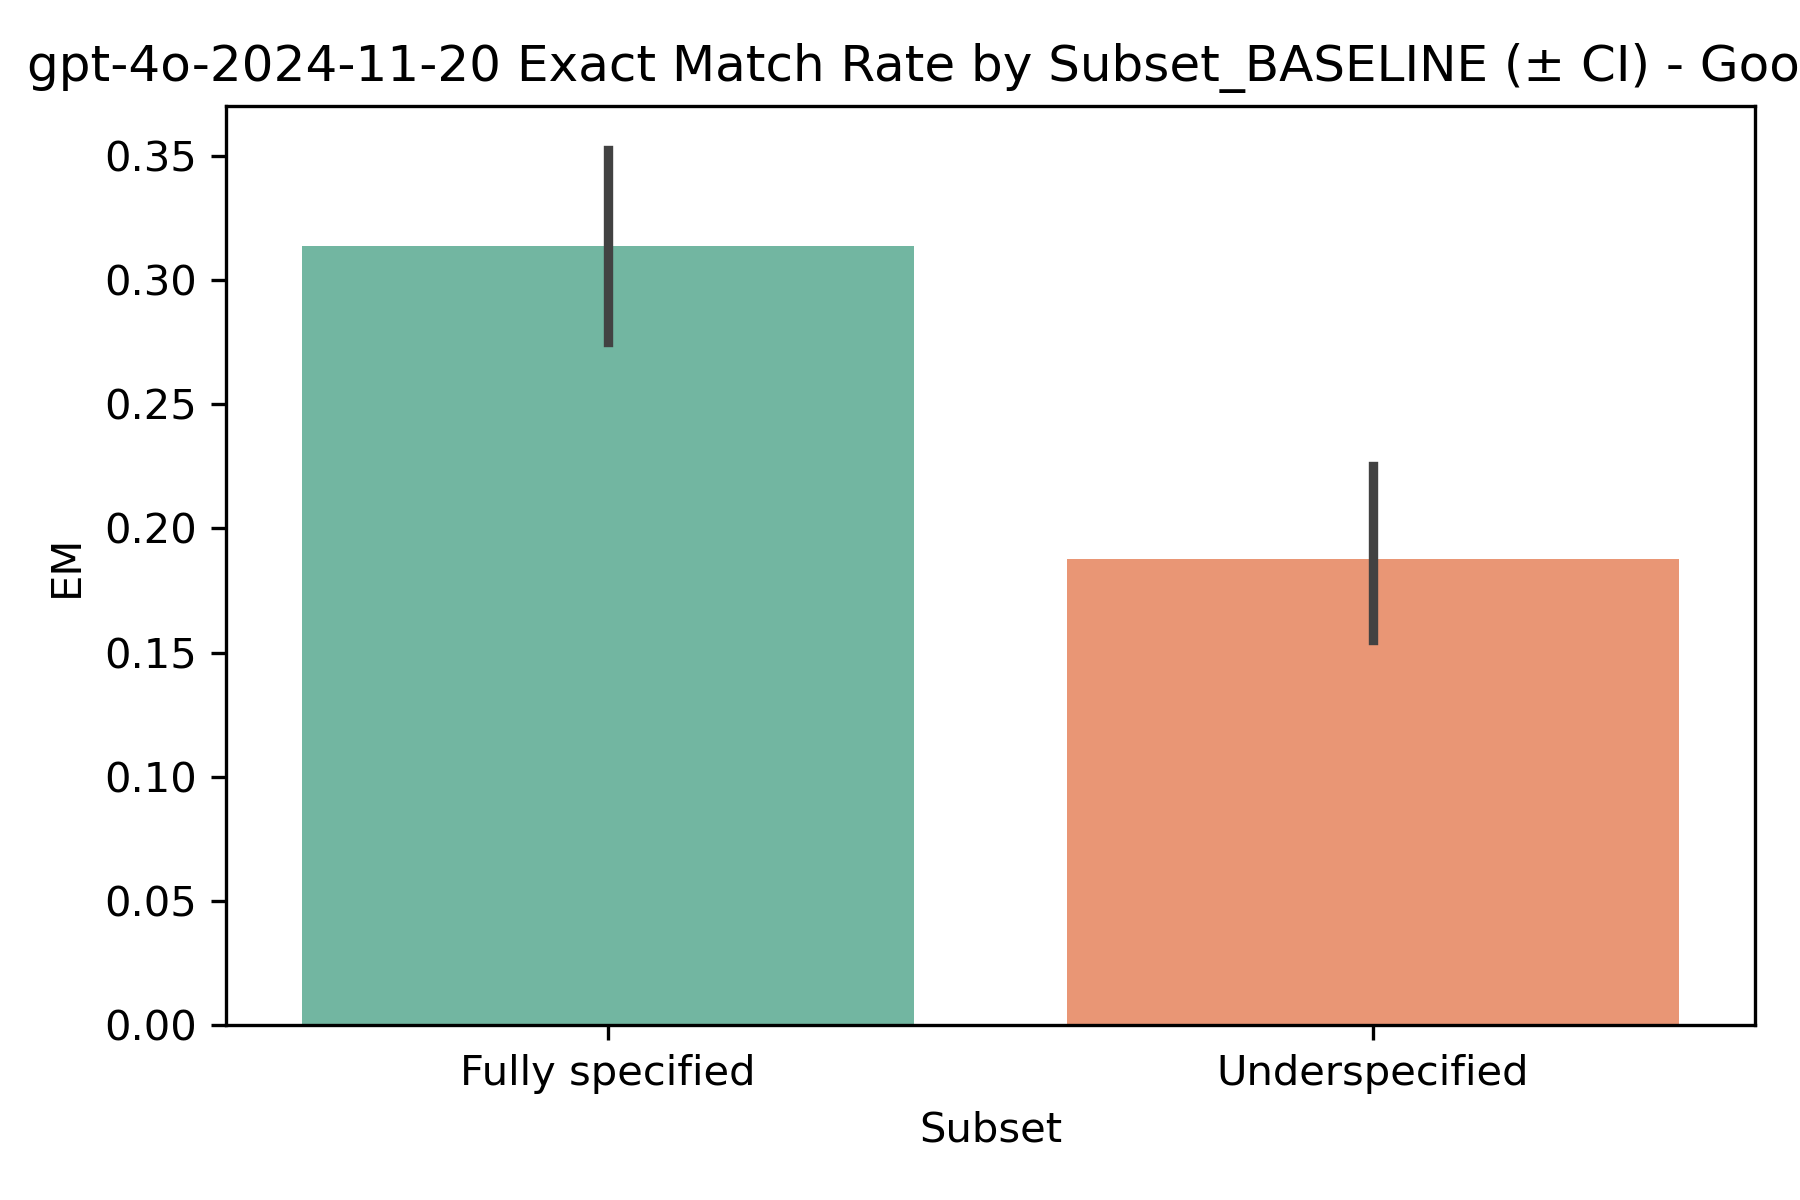

In [27]:
Image("GoogleNQ_em_barplot_gpt_BASELINE.png")

#### BLEU, ROUGE, METEOR, BERTScore

In [29]:
UND = load_dataset(
    "json",
    data_files="BASELINE_Google_NQ_UND_qa_gpt_with_squad_scores.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

FS = load_dataset(
    "json",
    data_files="BASELINE_Google_NQ_FS_qa_gpt_with_squad_scores.jsonl",
    split="train"
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [32]:
def evaluate_long_answer_all_metrics(
    dataset: Dataset,
    pred_col: str,
    ref_col: str,
    metrics: list = ["bleu", "meteor", "rouge", "bertscore"]
) -> dict:
    """
    对 dataset 中每条样本逐一计算多个文本生成评估指标。
    支持 BLEU, METEOR, ROUGE-L, BERTScore。

    Args:
        dataset: HuggingFace Dataset。
        pred_col: 模型预测列名（str）。
        ref_col: 参考答案列名（str）。
        metrics: 要计算的指标列表，支持 "bleu", "meteor", "rouge", "bertscore"。

    Returns:
        Dict[str, List[float]]: 每个指标对应一个分数列表。
    """
    metric_objects = {m: evaluate.load(m) for m in metrics}
    all_scores = {m: [] for m in metrics}

    for item in tqdm(dataset, desc="Evaluating metrics"):
        pred = item[pred_col]
        ref = item[ref_col]

        if not pred or not ref:
            for m in metrics:
                all_scores[m].append(0.0)
            continue

        for m in metrics:
            try:
                if m == "rouge":
                    result = metric_objects[m].compute(predictions=[pred], references=[[ref]])
                    all_scores[m].append(result["rougeL"])
                elif m == "bertscore":
                    result = metric_objects[m].compute(predictions=[pred], references=[ref], lang="en")
                    all_scores[m].append(result["f1"][0])  # 取 BERTScore F1 分数
                else:
                    result = metric_objects[m].compute(predictions=[pred], references=[[ref]])
                    all_scores[m].append(result[m])
            except Exception as e:
                print(f"Error scoring sample with {m}: {e}")
                all_scores[m].append(0.0)

    return all_scores

def add_scores_to_dataset(dataset, scores_dict):
    """
    将多个指标打分列表合并为 dataset 的新列。

    Args:
        dataset (Dataset): 原始 HuggingFace Dataset。
        scores_dict (dict): 如 {"bleu": [...], "meteor": [...]}，每个值都是 len=N 的分数列表。

    Returns:
        Dataset: 增加了评估分数的新数据集。
    """

    # 确保每个指标的分数长度与数据集行数一致
    for k, v in scores_dict.items():
        assert len(v) == len(dataset), f"Length mismatch for {k}: {len(v)} != {len(dataset)}"

    # 加入每个指标为新列
    new_dataset = dataset
    for k, v in scores_dict.items():
        new_dataset = new_dataset.add_column(k, v)

    return new_dataset
def t_test_metrics(scores_1: dict, scores_2: dict, label_1="Group 1", label_2="Group 2"):
    """
    对两个子集的多个指标进行 t-test，并打印结果。

    Args:
        scores_1 (dict): 子集 1 的评估分数，形式为 {"metric": [scores]}。
        scores_2 (dict): 子集 2 的评估分数，形式相同。
    """
    common_metrics = set(scores_1.keys()) & set(scores_2.keys())

    print(f"\nT-test results between {label_1} and {label_2}:\n")
    for metric in sorted(common_metrics):
        x = scores_1[metric]
        y = scores_2[metric]

        t_stat, p_val = ttest_ind(x, y, equal_var=False)
        print(f"{metric.upper():<10} | t = {t_stat:6.3f} | p = {p_val:.4f} | "
              f"{'significant' if p_val < 0.05 else 'not significant'}")

def plot_metric_distributions(scores_1, scores_2, label_1="Group 1", label_2="Group 2", filename="BASELINE_Google_NQ_metric_plot.png"):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    from IPython.display import Image

    # 构建 DataFrame
    rows = []
    for metric in scores_1:
        if metric in scores_2:
            for v in scores_1[metric]:
                rows.append({"score": v, "metric": metric.upper(), "group": label_1})
            for v in scores_2[metric]:
                rows.append({"score": v, "metric": metric.upper(), "group": label_2})
    df = pd.DataFrame(rows)

    # 绘图设置
    sns.set(style="whitegrid", font_scale=1.1)
    g = sns.catplot(
        data=df, kind="box", x="metric", y="score", hue="group",
        height=5, aspect=1.6, palette="Set2", showfliers=True  # Keep outliers，remove swarm
    )

    g.set_axis_labels("Metric", "Score")
    g.set_titles("Metric Score Distributions")
    g.despine(left=True)
    plt.title("gpt-4o-2024-11-20 Long Answer Evaluation Score Distributions by Group_BASELINE")
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()

    return Image(filename)

In [33]:
scores_UND = evaluate_long_answer_all_metrics(
    dataset=UND,
    pred_col="model_long_answer",
    ref_col="long_answer"
)

scores_FS = evaluate_long_answer_all_metrics(
    dataset=FS,
    pred_col="model_long_answer",
    ref_col="long_answer"
)

[nltk_data] Downloading package wordnet to /home/yhuang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/yhuang/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/yhuang/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Evaluating metrics:   0%|          | 0/458 [00:00<?, ?it/s]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating metrics: 100%|██████████| 458/458 [43:07<00:00,  5.65s/it]
[nltk_data] Downloading package wordnet to /home/yhuang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/yhuang/nltk_data...
[nltk_data]   Package punkt_tab 

In [34]:
# 合并
UND_with_most_metrics = add_scores_to_dataset(UND, scores_UND)
FS_with_most_metrics = add_scores_to_dataset(FS, scores_FS)

# 保存为新 jsonl（可选）
UND_with_most_metrics.to_json("BASELINE_GoogleNQ_UND_gpt_with_most_metrics.jsonl")
FS_with_most_metrics.to_json("BASELINE_GoogleNQ_FS_gpt_with_most_metrics.jsonl")

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

3576852

In [35]:
t_test_metrics(scores_FS, scores_UND, label_1="UND", label_2="FS")


T-test results between UND and FS:

BERTSCORE  | t =  1.382 | p = 0.1672 | not significant
BLEU       | t =  2.514 | p = 0.0121 | significant
METEOR     | t =  2.117 | p = 0.0345 | significant
ROUGE      | t =  3.208 | p = 0.0014 | significant


/home/yhuang/sglang-venv-2/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/scratch-local/yhuang.14598269/ipykernel_2864419/3514377990.py:117: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


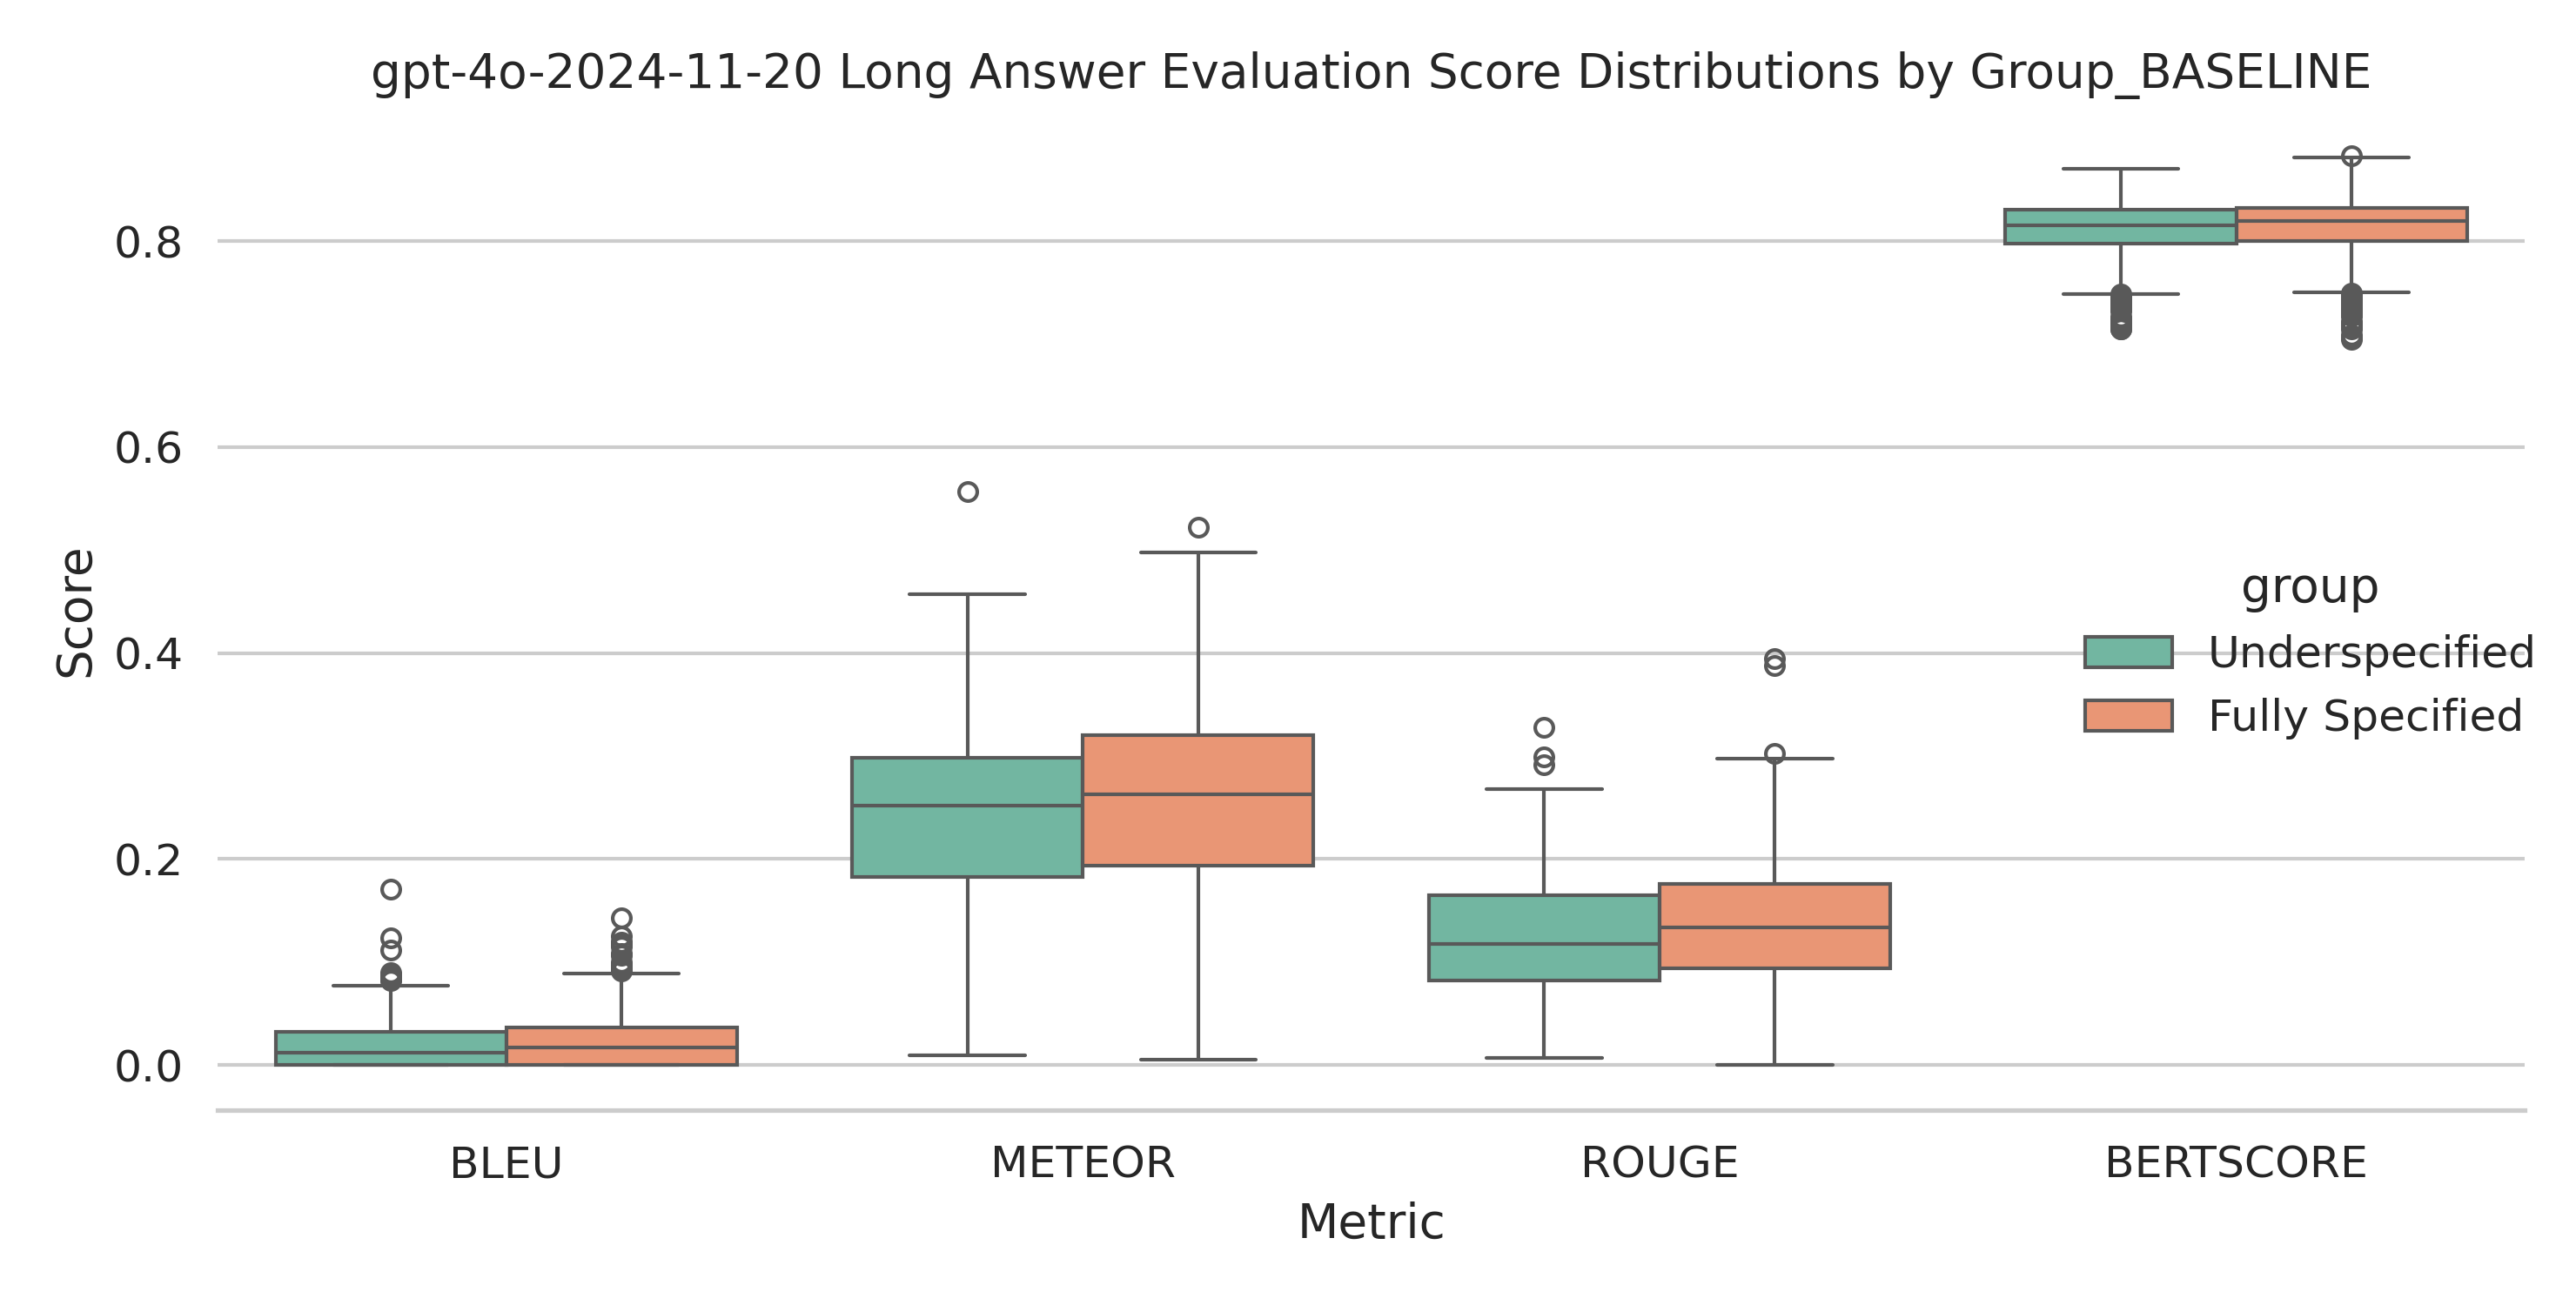

In [36]:
plot_metric_distributions(scores_UND, scores_FS, label_1="Underspecified", label_2="Fully Specified", filename="BASELINE_Google_NQ_metric_plot_gpt.png")

In [37]:
df = pd.read_json("BASELINE_GoogleNQ_UND_gpt_with_most_metrics.jsonl", lines=True)
df.to_csv('BASELINE_GoogleNQ_UND_gpt_with_most_metrics.csv')
df = pd.read_json("BASELINE_GoogleNQ_FS_gpt_with_most_metrics.jsonl", lines=True)
df.to_csv('BASELINE_GoogleNQ_FS_gpt_with_most_metrics.csv')

In [2]:
UND_full = load_dataset(
    "json",
    data_files="BASELINE_GoogleNQ_UND_gpt_with_most_metrics.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

FS_full = load_dataset(
    "json",
    data_files="BASELINE_GoogleNQ_FS_gpt_with_most_metrics.jsonl",
    split="train"
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [3]:
print(f'gpt_4o Google NQ UND qa average BLEU: {np.mean(UND_full["bleu"])}')
print(f'gpt_4o Google NQ FS qa average BLEU: {np.mean(FS_full["bleu"])}')
print(f'gpt_4o Google NQ UND qa average METEOR: {np.mean(UND_full["meteor"])}')
print(f'gpt_4o Google NQ FS qa average METEOR: {np.mean(FS_full["meteor"])}')
print(f'gpt_4o Google NQ UND qa average ROUGE: {np.mean(UND_full["rouge"])}')
print(f'gpt_4o Google NQ FS qa average ROUGE: {np.mean(FS_full["rouge"])}')
print(f'gpt_4o Google NQ UND qa average BERTSCORE: {np.mean(UND_full["bertscore"])}')
print(f'gpt_4o Google NQ FS qa average BERTSCORE: {np.mean(FS_full["bertscore"])}')

gpt_4o Google NQ UND qa average BLEU: 0.019053965891703058
gpt_4o Google NQ FS qa average BLEU: 0.023032879204428043
gpt_4o Google NQ UND qa average METEOR: 0.23435758013973798
gpt_4o Google NQ FS qa average METEOR: 0.24750715377804433
gpt_4o Google NQ UND qa average ROUGE: 0.12360671846266374
gpt_4o Google NQ FS qa average ROUGE: 0.13550989616623615
gpt_4o Google NQ UND qa average BERTSCORE: 0.8089879748613538
gpt_4o Google NQ FS qa average BERTSCORE: 0.8117569594822879


In [4]:
print(f'gpt_4o Google NQ UND qa EM SD: {np.std(UND_full["em"])}')
print(f'gpt_4o Google NQ FS qa EM SD: {np.std(FS_full["em"])}')
print(f'gpt_4o Google NQ UND qa F1 SD: {np.std(UND_full["f1"])}')
print(f'gpt_4o Google NQ FS qa F1 SD: {np.std(FS_full["f1"])}')

gpt_4o Google NQ UND qa EM SD: 0.3905307338919016
gpt_4o Google NQ FS qa EM SD: 0.46397720469372417
gpt_4o Google NQ UND qa F1 SD: 0.375792454605358
gpt_4o Google NQ FS qa F1 SD: 0.40970595875810145


In [8]:
print(f'gpt_4o Google NQ UND qa BLEU SD: {np.std(UND_full["bleu"]) * 100:.1f}')
print(f'gpt_4o Google NQ FS qa BLEU SD: {np.std(FS_full["bleu"])* 100:.1f}')
print(f'gpt_4o Google NQ UND qa METEOR SD: {np.std(UND_full["meteor"])* 100:.1f}')
print(f'gpt_4o Google NQ FS qa METEOR SD: {np.std(FS_full["meteor"])* 100:.1f}')
print(f'gpt_4o Google NQ UND qa ROUGE SD: {np.std(UND_full["rouge"])* 100:.1f}')
print(f'gpt_4o Google NQ FS qa ROUGE SD: {np.std(FS_full["rouge"])* 100:.1f}')
print(f'gpt_4o Google NQ UND qa BERTSCORE SD: {np.std(UND_full["bertscore"])* 100:.1f}')
print(f'gpt_4o Google NQ FS qa BERTSCORE SD: {np.std(FS_full["bertscore"])* 100:.1f}')

gpt_4o Google NQ UND qa BLEU SD: 2.4
gpt_4o Google NQ FS qa BLEU SD: 2.6
gpt_4o Google NQ UND qa METEOR SD: 9.5
gpt_4o Google NQ FS qa METEOR SD: 10.1
gpt_4o Google NQ UND qa ROUGE SD: 5.7
gpt_4o Google NQ FS qa ROUGE SD: 6.0
gpt_4o Google NQ UND qa BERTSCORE SD: 3.0
gpt_4o Google NQ FS qa BERTSCORE SD: 3.3


In [28]:
def welch_df(n1, sd1, n2, sd2):
    var1 = sd1**2
    var2 = sd2**2
    numerator = (var1/n1 + var2/n2)**2
    denominator = ((var1/n1)**2)/(n1 - 1) + ((var2/n2)**2)/(n2 - 1)
    return numerator / denominator

In [29]:
welch_df(300, np.std(UND_full["em"]), 700, np.std(FS_full["em"]))

698.4565580903487

In [30]:
welch_df(300, np.std(UND_full["f1"]), 700, np.std(FS_full["f1"]))

625.5775505065059

### Ragas evaluation

In [2]:
evaluator_llm = LangchainLLMWrapper(ChatDeepSeek(model="deepseek-chat", verbose=True, temperature=0))

UND_full = load_dataset(
    "json",
    data_files="BASELINE_GoogleNQ_UND_gpt_with_most_metrics.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

FS_full = load_dataset(
    "json",
    data_files="BASELINE_GoogleNQ_FS_gpt_with_most_metrics.jsonl",
    split="train"
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [3]:
async def answer_accuracy(input_dataset, long_answer=False, evaluator=evaluator_llm):
    # 在函数开始时创建一次 scorer
    scorer = AnswerAccuracy(llm=evaluator)
    
    if long_answer:
        score_list_long = []
        score_list_short = []
        
        for i, row in enumerate(tqdm(input_dataset, desc="Calculating short and long answer accuracy")):
            try:
                # 长答案评分
                if 'model_long_answer' in row and 'long_answer' in row:
                    sample_long = SingleTurnSample(
                        user_input=row['question'],
                        response=row['model_long_answer'],
                        reference=row['long_answer']
                    )
                    score_long = await scorer.single_turn_ascore(sample_long)
                    score_list_long.append(score_long)
                else:
                    score_list_long.append(0.0)

                # 短答案评分 - 处理列表情况
                if 'model_short_answer' in row and 'short_answers' in row:
                    model_answers = row['model_short_answer'] if isinstance(row['model_short_answer'], list) else [row['model_short_answer']]
                    reference_answers = row['short_answers'] if isinstance(row['short_answers'], list) else [row['short_answers']]
                    
                    # 计算所有组合的分数，取最高分
                    max_score = 0.0
                    for model_ans in model_answers:
                        for ref_ans in reference_answers:
                            sample_short = SingleTurnSample(
                                user_input=row['question'],
                                response=model_ans,
                                reference=ref_ans
                            )
                            score = await scorer.single_turn_ascore(sample_short)
                            max_score = max(max_score, score)
                    
                    score_list_short.append(max_score)
                else:
                    score_list_short.append(0.0)
                
            except Exception as e:
                print(f"处理第 {i+1} 个样本时出错: {e}")
                score_list_long.append(0.0)
                score_list_short.append(0.0)

        ragas_scored_dataset = input_dataset.add_column("ragas_AA_long", score_list_long)
        ragas_scored_dataset = ragas_scored_dataset.add_column("ragas_AA_short", score_list_short)

        return ragas_scored_dataset
    else:
        score_list = []
        
        for i, row in enumerate(tqdm(input_dataset, desc="Calculating short answer accuracy")):
            try:
                # 短答案评分 - 处理列表情况
                if 'model_short_answer' in row and 'short_answers' in row:
                    model_answers = row['model_short_answer'] if isinstance(row['model_short_answer'], list) else [row['model_short_answer']]
                    reference_answers = row['short_answers'] if isinstance(row['short_answers'], list) else [row['short_answers']]
                    
                    # 计算所有组合的分数，取最高分
                    max_score = 0.0
                    for model_ans in model_answers:
                        for ref_ans in reference_answers:
                            sample = SingleTurnSample(
                                user_input=row['question'],
                                response=model_ans,
                                reference=ref_ans
                            )
                            score = await scorer.single_turn_ascore(sample)
                            max_score = max(max_score, score)
                    
                    score_list.append(max_score)
                else:
                    score_list.append(0.0)
                
            except Exception as e:
                print(f"处理第 {i+1} 个样本时出错: {e}")
                score_list.append(0.0)

        ragas_scored_dataset = input_dataset.add_column("ragas_AA_short", score_list)

        return ragas_scored_dataset

In [4]:
UND_ragas = await answer_accuracy(UND_full)
UND_ragas.to_csv("GoogleNQ_UND_gpt4o_Ragas.csv")

Calculating short answer accuracy: 100%|██████████| 458/458 [3:18:46<00:00, 26.04s/it]     


Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

3082445

In [5]:
FS_ragas = await answer_accuracy(FS_full)
FS_ragas.to_csv("GoogleNQ_FS_gpt4o_Ragas.csv")

Calculating short answer accuracy: 100%|██████████| 542/542 [2:16:49<00:00, 15.15s/it]    


Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

3443871

In [6]:
UND_ragas_AA = list(UND_ragas["ragas_AA_short"])
FS_ragas_AA = list(FS_ragas["ragas_AA_short"])

UND_mean_AA = np.mean(UND_ragas_AA)
print(f"UND AA (avg): {UND_mean_AA * 100:.2f}")


FS_mean_AA = np.mean(FS_ragas_AA)
print(f"FS AA (avg): {FS_mean_AA * 100:.2f}")

AA_tstat, AA_pval = ttest_ind(FS_ragas_AA, UND_ragas_AA, equal_var=False)
print(f"AA: t={AA_tstat:.3f}, p={AA_pval:.4f}")

UND AA (avg): 57.97
FS AA (avg): 69.33
AA: t=4.151, p=0.0000
